<div style="text-align: right"> Tommy Evans-Barton </div>
<div style="text-align: right"> WR Year 2 Jumps </div>

# Analysis and Modeling Notebook

The purpose of this notebook is to develop the model used to predict second year production for receivers based on their statistics in their first year. This notebook will also serve as a preliminary 'final notebook' before the final presentation of this project's findings.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import scipy.stats
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
TOP_PATH = os.environ['PWD']

## Reading in Data

In [4]:
df = pd.read_csv(TOP_PATH + '/data/final/FINAL_DATA.csv')
df

,Rnd,Pick,Team,Player,First Year,Age Draft,G,GS,Tgt,WR Tgt Share,...,Projected Rec Share,Projected Rec,Projected Yds Share,Projected Yds,Projected TD Share,Projected TD,Rec Pts First Season,Rec Pts/G First Season,Rec Pts Second Season,Rec Pts/G Second Season
0,1,3,CLE,B.Edwards,2005,22,10.0,7.0,59.0,0.226923,...,0.425007,61.201005,0.498598,981.739542,0.222222,2.0,69.2,6.920000,124.4,7.775000
1,1,7,MIN,T.Williamson,2005,22,14.0,3.0,52.0,0.180556,...,0.484076,76.000000,0.483380,1047.000000,0.307692,4.0,49.2,3.514286,45.5,3.250000
2,1,10,DET,M.Williams,2005,21,14.0,4.0,57.0,0.256757,...,0.381579,43.500000,0.257708,374.707921,-0.444444,-4.0,41.0,2.928571,15.9,1.987500
3,1,21,JAX,M.Jones,2005,22,16.0,1.0,69.0,0.206587,...,0.582418,106.000000,0.563735,1455.000000,0.611111,11.0,73.2,4.575000,88.3,6.307143
4,1,22,BAL,M.Clayton,2005,23,14.0,10.0,87.0,0.388393,...,0.338462,44.000000,0.305052,471.000000,0.400000,2.0,59.1,4.221429,123.9,7.743750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,2,57,PHI,J.Arcega-Whiteside,2019,22,16.0,5.0,22.0,0.126437,...,0.485149,49.000000,0.450466,532.000000,0.400000,4.0,22.9,1.431250,NaN,NaN
127,2,64,SEA,D.Metcalf,2019,21,16.0,15.0,100.0,0.375940,...,0.424419,73.000000,0.457451,1145.000000,0.444444,8.0,132.0,8.250000,NaN,NaN
128,3,66,PIT,D.Johnson,2019,23,16.0,12.0,92.0,0.380165,...,0.406897,59.000000,0.345704,680.000000,0.454545,5.0,98.0,6.125000,NaN,NaN
129,3,76,WAS,T.McLaurin,2019,23,14.0,14.0,93.0,0.505435,...,0.508772,58.000000,0.620108,919.000000,0.875000,7.0,133.9,9.564286,NaN,NaN


## Splitting the Data into Modeling and Prediction Data
Some of the data (the players who have not yet had second seasons) don't have a target for us to model onto, since this is a 'supervised learning' problem. These players will be moved into a different dataframe for future use.

In [5]:
df_model = df[df['First Year'] < 2019].reset_index(drop = True)
df_prediction = df[df['First Year'] == 2019].reset_index(drop = True)

In [6]:
df_model

,Rnd,Pick,Team,Player,First Year,Age Draft,G,GS,Tgt,WR Tgt Share,...,Projected Rec Share,Projected Rec,Projected Yds Share,Projected Yds,Projected TD Share,Projected TD,Rec Pts First Season,Rec Pts/G First Season,Rec Pts Second Season,Rec Pts/G Second Season
0,1,3,CLE,B.Edwards,2005,22,10.0,7.0,59.0,0.226923,...,0.425007,61.201005,0.498598,981.739542,0.222222,2.000000,69.2,6.920000,124.4,7.775000
1,1,7,MIN,T.Williamson,2005,22,14.0,3.0,52.0,0.180556,...,0.484076,76.000000,0.483380,1047.000000,0.307692,4.000000,49.2,3.514286,45.5,3.250000
2,1,10,DET,M.Williams,2005,21,14.0,4.0,57.0,0.256757,...,0.381579,43.500000,0.257708,374.707921,-0.444444,-4.000000,41.0,2.928571,15.9,1.987500
3,1,21,JAX,M.Jones,2005,22,16.0,1.0,69.0,0.206587,...,0.582418,106.000000,0.563735,1455.000000,0.611111,11.000000,73.2,4.575000,88.3,6.307143
4,1,22,BAL,M.Clayton,2005,23,14.0,10.0,87.0,0.388393,...,0.338462,44.000000,0.305052,471.000000,0.400000,2.000000,59.1,4.221429,123.9,7.743750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2,51,CHI,A.Miller,2018,23,15.0,4.0,54.0,0.192171,...,0.544404,98.537037,0.495570,1036.732673,0.533333,8.000000,84.3,5.620000,77.6,4.850000
117,2,60,PIT,J.Washington,2018,22,14.0,6.0,38.0,0.094763,...,0.550607,136.000000,0.532306,1623.000000,0.695652,16.000000,27.7,1.978571,91.5,6.100000
118,2,61,JAX,D.Chark,2018,21,11.0,0.0,32.0,0.109589,...,0.208546,34.618557,0.291061,596.675743,0.148148,1.333333,17.4,1.581818,148.8,9.920000
119,3,81,DAL,M.Gallup,2018,22,16.0,8.0,68.0,0.311927,...,0.787760,107.923077,0.795709,1346.339575,0.677778,6.100000,62.7,3.918750,146.7,10.478571


## Train-Valid-Test Splitting
Next I'm going to split the modeling data into pieces in order to have part of it to train the model on, and part of it to test on. In terms of the training, I chose to use the k-folds cross validation strategy, due to the low amount of samples, with k = 5.

In [376]:
X_full_train, X_test, y_full_train, y_test = train_test_split(df_model.drop(
    ['Rec Pts Second Season', 'Rec Pts/G Second Season'], axis = 1), 
    df_model['Rec Pts/G Second Season'], test_size = 0.2, random_state = 3)
X_full_train = X_full_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_full_train = y_full_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [377]:
np.random.seed(12)
indices = np.random.choice(len(X_full_train.index), len(X_full_train.index), replace = False)
splitter = len(indices)//5
fold_1_x = X_full_train.iloc[indices[: splitter]]
fold_1_y = y_full_train.iloc[indices[: splitter]]
fold_2_x = X_full_train.iloc[indices[splitter : 2 * splitter]]
fold_2_y = y_full_train.iloc[indices[splitter : 2 * splitter]]
fold_3_x = X_full_train.iloc[indices[2 * splitter : 3 * splitter]]
fold_3_y = y_full_train.iloc[indices[2 * splitter : 3 * splitter]]
fold_4_x = X_full_train.iloc[indices[3 * splitter : 4 * splitter]]
fold_4_y = y_full_train.iloc[indices[3 * splitter : 4 * splitter]]
fold_5_x = X_full_train.iloc[indices[4 * splitter :]]
fold_5_y = y_full_train.iloc[indices[4 * splitter :]]

## Create a Baseline Model
Its important to have some kind of baseline (or dummy) model to compare our model to. For the purposes of this project, the baseline will be predicting that the receiver has the same Rec Pts/G in their second season as their first. 

Based on this, it seems that the average $R^2$ coefficient for the baseline is around *0.216*, giving us the number to beat.

In [378]:
fold_1_y_baseline = fold_1_x['Rec Pts/G First Season']
fold_2_y_baseline = fold_2_x['Rec Pts/G First Season']
fold_3_y_baseline = fold_3_x['Rec Pts/G First Season']
fold_4_y_baseline = fold_4_x['Rec Pts/G First Season']
fold_5_y_baseline = fold_5_x['Rec Pts/G First Season']

In [379]:
print(r2_score(fold_5_y, fold_5_y_baseline))
print(r2_score(fold_4_y, fold_4_y_baseline))
print(r2_score(fold_3_y, fold_3_y_baseline))
print(r2_score(fold_2_y, fold_2_y_baseline))
print(r2_score(fold_1_y, fold_1_y_baseline))
print('--------------------')
print(np.mean([r2_score(fold_5_y, fold_5_y_baseline), r2_score(fold_4_y, fold_4_y_baseline), 
              r2_score(fold_3_y, fold_3_y_baseline), r2_score(fold_2_y, fold_2_y_baseline), 
              r2_score(fold_1_y, fold_1_y_baseline)]))

0.1797271534597592
0.44815436291566646
-0.08994188232781553
0.1877306170680606
0.35799257258639594
--------------------
0.21673256474041333


## Building the Model

### Defining and Sorting the Different Features

In [625]:
cat_feat = ['Age Draft']
thresh_feat = ['GS']
reg_num_feat = ['Pick', 'First Year', 'G', 'GS',
        'Tgt', 'Catch Rate', 'Y/R', 'TD', 'WR TD Share', 'Lng', 'Y/Tgt', 'Y/G', 
        'Projected Tgt Share', 'Projected Tgt', 'Projected Rec Share', 'Projected Rec', 'Projected Yds Share',
        'Projected Yds', 'Projected TD Share', 'Projected TD']
sqrt_num_feat = ['WR Tgt Share', 'Rec', 'WR Rec Share', 'Yds', 'WR Yds Share', '1D', 
                 'R/G', 'EYds', 'Rec Pts First Season', 'Rec Pts/G First Season']
adv_num_feat = ['DYAR', 'YAR', 'DVOA', 'VOA', 'DPI Pens', 'DPI Yds']
num_feat = reg_num_feat + sqrt_num_feat + adv_num_feat


small_selection = ['Y/G', 'Lng', 'Projected Yds']
small_sqrt = ['Yds', '1D', 'EYds', 'Rec Pts/G First Season', 'WR Tgt Share', 'WR Rec Share']

### Defining the Different Transformers

In [626]:
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(categories = 'auto'))     # categorical columns become input to OneHot
])

thresh_transformer = Pipeline(steps=[
    ('binarizer', Binarizer(threshold = 8))
])

sqrt_transformer = Pipeline(steps = [
    ('sqrt', FunctionTransformer(lambda x : x**.5))
])

num_transformer = Pipeline(steps=[
    ('none', FunctionTransformer(lambda x : x))
])

preproc1 = ColumnTransformer(transformers=[('sqrt', sqrt_transformer, small_sqrt), 
                                           ('none', num_transformer, small_selection), 
                                           ('cat', cat_transformer, cat_feat), 
                                           ('thresh', thresh_transformer, thresh_feat)])

### Defining the Different Pipelines

In [627]:
pl_1 = Pipeline(steps=[('preprocessor', preproc1), ('regressor', Ridge(alpha = .7, normalize = True))]) #k5 as valid
pl_2 = Pipeline(steps=[('preprocessor', preproc1), ('regressor', Ridge(alpha = .7, normalize = True))]) #k4 as valid
pl_3 = Pipeline(steps=[('preprocessor', preproc1), ('regressor', Ridge(alpha = .7, normalize = True))]) #k3 as valid
pl_4 = Pipeline(steps=[('preprocessor', preproc1), ('regressor', Ridge(alpha = .7, normalize = True))]) #k2 as valid
pl_5 = Pipeline(steps=[('preprocessor', preproc1), ('regressor', Ridge(alpha = .7, normalize = True))]) #k1 as valid

### Fit the Different Pipelines

In [628]:
pl_1.fit(pd.concat([fold_1_x, fold_2_x, fold_3_x, fold_4_x])[small_selection + small_sqrt + cat_feat + thresh_feat],
         pd.concat([fold_1_y, fold_2_y, fold_3_y, fold_4_y]))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('sqrt',
                                                  Pipeline(memory=None,
                                                           steps=[('sqrt',
                                                                   FunctionTransformer(accept_sparse=False,
                                                                                       check_inverse=True,
                                                                                       func=<function <lambda> at 0x7f929026ca70>,
                                                                                       inv_kw_args=None,
                                                                                       inverse_func=None,

In [629]:
pl_2.fit(pd.concat([fold_1_x, fold_2_x, fold_3_x, fold_5_x])[small_selection + small_sqrt + cat_feat + thresh_feat],
         pd.concat([fold_1_y, fold_2_y, fold_3_y, fold_5_y]))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('sqrt',
                                                  Pipeline(memory=None,
                                                           steps=[('sqrt',
                                                                   FunctionTransformer(accept_sparse=False,
                                                                                       check_inverse=True,
                                                                                       func=<function <lambda> at 0x7f929026ca70>,
                                                                                       inv_kw_args=None,
                                                                                       inverse_func=None,

In [630]:
pl_3.fit(pd.concat([fold_1_x, fold_2_x, fold_4_x, fold_5_x])[small_selection + small_sqrt + cat_feat + thresh_feat],
         pd.concat([fold_1_y, fold_2_y, fold_4_y, fold_5_y]))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('sqrt',
                                                  Pipeline(memory=None,
                                                           steps=[('sqrt',
                                                                   FunctionTransformer(accept_sparse=False,
                                                                                       check_inverse=True,
                                                                                       func=<function <lambda> at 0x7f929026ca70>,
                                                                                       inv_kw_args=None,
                                                                                       inverse_func=None,

In [631]:
pl_4.fit(pd.concat([fold_1_x, fold_3_x, fold_4_x, fold_5_x])[small_selection + small_sqrt + cat_feat + thresh_feat],
         pd.concat([fold_1_y, fold_3_y, fold_4_y, fold_5_y]))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('sqrt',
                                                  Pipeline(memory=None,
                                                           steps=[('sqrt',
                                                                   FunctionTransformer(accept_sparse=False,
                                                                                       check_inverse=True,
                                                                                       func=<function <lambda> at 0x7f929026ca70>,
                                                                                       inv_kw_args=None,
                                                                                       inverse_func=None,

In [632]:
pl_5.fit(pd.concat([fold_2_x, fold_3_x, fold_4_x, fold_5_x])[small_selection + small_sqrt + cat_feat + thresh_feat],
         pd.concat([fold_2_y, fold_3_y, fold_4_y, fold_5_y]))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('sqrt',
                                                  Pipeline(memory=None,
                                                           steps=[('sqrt',
                                                                   FunctionTransformer(accept_sparse=False,
                                                                                       check_inverse=True,
                                                                                       func=<function <lambda> at 0x7f929026ca70>,
                                                                                       inv_kw_args=None,
                                                                                       inverse_func=None,

In [633]:
score_1 = pl_1.score(fold_5_x[small_selection + small_sqrt + cat_feat + thresh_feat], fold_5_y)
score_2 = pl_2.score(fold_4_x[small_selection + small_sqrt + cat_feat + thresh_feat], fold_4_y)
score_3 = pl_3.score(fold_3_x[small_selection + small_sqrt + cat_feat + thresh_feat], fold_3_y)
score_4 = pl_4.score(fold_2_x[small_selection + small_sqrt + cat_feat + thresh_feat], fold_2_y)
score_5 = pl_5.score(fold_1_x[small_selection + small_sqrt + cat_feat + thresh_feat], fold_1_y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning:

In [634]:
print(score_1)
print(score_2)
print(score_3)
print(score_4)
print(score_5)
print('--------------------')
print('MEAN SCORE: ' + str(np.mean([score_1, score_2, score_3, score_4, score_5])))
print('MEDIAN SCORE: ' + str(np.median([score_1, score_2, score_3, score_4, score_5])))

0.4697622510810015
0.5187625482625597
0.4576968079256763
0.3428075787115199
0.41442693504231337
--------------------
MEAN SCORE: 0.44069122420461415
MEDIAN SCORE: 0.4576968079256763


In [608]:
coefs_mean = (pl_1.named_steps['regressor'].coef_ + pl_2.named_steps['regressor'].coef_ 
                + pl_3.named_steps['regressor'].coef_ + pl_4.named_steps['regressor'].coef_ 
                    + pl_5.named_steps['regressor'].coef_) / 5
intercept_mean = (pl_1.named_steps['regressor'].intercept_ + pl_2.named_steps['regressor'].intercept_ 
                        + pl_3.named_steps['regressor'].intercept_ + pl_4.named_steps['regressor'].intercept_ 
                            + pl_5.named_steps['regressor'].intercept_) / 5

In [609]:
coefs_mean

array([ 5.45817862e-02,  2.29819010e-01,  4.82258966e-02,  5.46704011e-01,
       -2.94806195e-01, -7.46397055e-01,  2.94242502e-02, -5.23391507e-03,
        6.68315980e-04,  1.64702345e+00,  4.34265138e-01, -2.99508097e-01,
       -5.52203539e-01,  6.20203350e-01, -1.46645338e-01])

In [610]:
intercept_mean

1.2064671081672218

In [611]:
df_coeff = pd.DataFrame(zip(small_selection + small_sqrt + 
                            list(set(X_full_train['Age Draft'].unique())) + thresh_feat, coefs_mean))
df_coeff.columns = ['Feature', 'Coefficient']
df_coeff

,Feature,Coefficient
0,Y/G,0.054582
1,Lng,0.229819
2,Projected Yds,0.048226
3,Yds,0.546704
4,1D,-0.294806
5,EYds,-0.746397
6,Rec Pts/G First Season,0.029424
7,WR Tgt Share,-0.005234
8,WR Rec Share,0.000668
9,20,1.647023


In [612]:
pl_final = Pipeline(steps=[('preprocessor', preproc1), ('regressor', Ridge(alpha = .7, normalize = True))])
pl_final.named_steps['regressor'].coef_ = coefs_mean
pl_final.named_steps['regressor'].intercept_ = intercept_mean

In [613]:
y_train_pred = pl_final.predict(X_full_train[small_selection + small_sqrt + cat_feat + thresh_feat])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


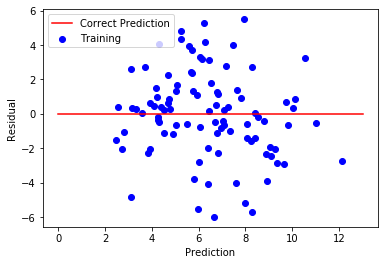

In [614]:
plt.scatter(y_train_pred, y_train_pred - y_full_train, c = 'b', label = 'Training')
plt.plot(range(14), [0] * 14, color = 'r', label = 'Correct Prediction')
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.legend(loc='upper left')
plt.show()
#Save this FIGURE and then 